# Factorización matricial vectorizada

**Autor**: Arturo Sánchez Palacio

Basado en: https://github.com/lazyprogrammer

**Fecha de última revisión: 19/I/2020**

En este cuaderno emplearemos los siguientes módulos:

In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Como ya es habitual comenzamos cargando los datos almacenados en forma de diccionario:

In [2]:
with open('./data/usuario_pelicula.json', 'rb') as f:
  usuario_pelicula = pickle.load(f)

with open('./data/pelicula_usuario.json', 'rb') as f:
  pelicula_usuario = pickle.load(f)

with open('./data/usuariopeli_rating.json', 'rb') as f:
  usuariopeli_rating = pickle.load(f)

with open('./data/usuariopeli_rating_test.json', 'rb') as f:
  usuariopeli_rating_test = pickle.load(f)

De nuevo fijamos los valores de N y M como ya es habitual:

In [5]:
N = np.max(list(usuario_pelicula.keys())) + 1
m_train = np.max(list(pelicula_usuario.keys()))
m_test = np.max([m for (u, m), r in usuariopeli_rating_test.items()])
M = max(m_train, m_test) + 1
print("N:", N, "M:", M)

N: 2500 M: 1000


Inicializamos las variables inicializando las matrices aleatoriamente, los vectores a cero, calculando la media global y eligiendo K (dimensión de la reducción):

In [6]:
K = 10 # dimensionalidad latente
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usuariopeli_rating.values()))

__Nota__ Aquí empiezan las variaciones respecto al notebook anterio.

Para optimizar el procesamiento y no tener bucles anidados creamos distintos diccionarios. El primero `usuario_pelirating` tiene por clave el usuario y por valor una tupla de película y rating:

In [7]:
usuario_pelirating = {}
for i, peliculas in usuario_pelicula.items():
    r = np.array([usuariopeli_rating[(i,j)] for j in peliculas])
    usuario_pelirating[i] = (peliculas, r)

El segundo `peli_usuariorating` tiene por clave las películas y por valor una tupla de usuario y rating:

In [8]:
peli_usuariorating = {}
for j, users in pelicula_usuario.items():
  r = np.array([usuariopeli_rating[(i,j)] for i in users])
  peli_usuariorating[j] = (users, r)

El último `peli_usuariorating_test` es análogo para test:

In [9]:
peli_usuariorating_test = {}
for (i, j), r in usuariopeli_rating_test.items():
    if j not in peli_usuariorating_test:
        peli_usuariorating_test[j] = [[i], [r]]
    else:
        peli_usuariorating_test[j][0].append(i)
        peli_usuariorating_test[j][1].append(r)
for j, (users, r) in peli_usuariorating_test.items():
      peli_usuariorating_test[j][1] = np.array(r)

Recordemos la fórmula de la predicción:

![Formulas prediccion](./media/formula_pred.png)

Definimos una función que calcula la pérdida dado el diccionario usuariopeli_ratings:

In [10]:
def get_loss(dicc):
    N = 0.
    sse = 0
    for j, (u_ids, r) in dicc.items():  #iteramos en el diccionario 
        p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu #obtenemos nuestra predicción
        delta = p - r
        sse += delta.dot(delta) #calculamos el arror cuadrático
        N += len(r)
    return sse / N #dividir por N devuelve el error medio cuadrático

Una vez definida la función construimos el bucle de entrenamiento. Comenzamos fijando el número de iteraciones, el coeficiente de regularización e inicializando dos listas para almacenar las pérdidas:

In [11]:
iteraciones = 25
reg =20. 
perdidas_entren = []
perdidas_test = []

__Nota.__ Recordemos las fórmulas de los coeficientes que queremos calcular:

![Formulas regulizacion](./media/formulas_reg.png)

El bucle de entrenamiento itera durante las iteraciones fijadas:

In [12]:
for iteracion in range(iteraciones):
    print("Iteración:", iteracion)
    iteracion_start = datetime.now() #calcular tiempo en cada iteración
    
    # Actualizamos los parámetros W y b:
    t0 = datetime.now()
    for i in range(N):
        m_ids, r = usuario_pelirating[i]
        matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
        vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
        bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

    # Actualizamos
        W[i] = np.linalg.solve(matrix, vector)
        b[i] = bi / (len(usuario_pelicula[i]) + reg)

        if i % (N//10) == 0:
            print("i:", i, "N:", N)
        print("Actualizados W y B:", datetime.now() - t0)
    
    # Calculamos ahora U y c:
    t0 = datetime.now()
    for j in range(M):
        try:
            u_ids, r = peli_usuariorating[j]
            matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
            vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
            cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

      # Actualizamos
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(pelicula_usuario[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
      # Es posible que la película no haya sido valorada:
            pass
    print("Actualizados U y c:", datetime.now() - t0)
    print("Duración de la iteración:", datetime.now() - iteracion_start)
    
    # Almacenamos la pérdida de entrenamiento y test:
    t0 = datetime.now()
    perdidas_entren.append(get_loss(peli_usuariorating))
    perdidas_test.append(get_loss(peli_usuariorating_test))
    print("Tiempo estimado:", datetime.now() - t0)
    print("Pérdida entrenamiento:", perdidas_entren[-1])
    print("Pérdida test:", perdidas_test[-1])

Iteración: 0
i: 0 N: 2500
Actualizados W y B: 0:00:00.424863
Actualizados W y B: 0:00:00.425861
Actualizados W y B: 0:00:00.449797
Actualizados W y B: 0:00:00.450794
Actualizados W y B: 0:00:00.451792
Actualizados W y B: 0:00:00.452789
Actualizados W y B: 0:00:00.453786
Actualizados W y B: 0:00:00.454784
Actualizados W y B: 0:00:00.455781
Actualizados W y B: 0:00:00.456778
Actualizados W y B: 0:00:00.456778
Actualizados W y B: 0:00:00.457776
Actualizados W y B: 0:00:00.458773
Actualizados W y B: 0:00:00.459770
Actualizados W y B: 0:00:00.460768
Actualizados W y B: 0:00:00.461765
Actualizados W y B: 0:00:00.462763
Actualizados W y B: 0:00:00.463760
Actualizados W y B: 0:00:00.464757
Actualizados W y B: 0:00:00.465754
Actualizados W y B: 0:00:00.466752
Actualizados W y B: 0:00:00.467749
Actualizados W y B: 0:00:00.468746
Actualizados W y B: 0:00:00.469744
Actualizados W y B: 0:00:00.470741
Actualizados W y B: 0:00:00.471738
Actualizados W y B: 0:00:00.472736
Actualizados W y B: 0:00:00.4

Finalmente podemos observar las pérdidas en una gráfica:

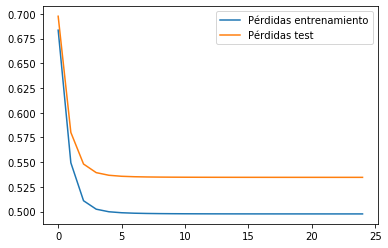

In [13]:
plt.plot(perdidas_entren, label="Pérdidas entrenamiento")
plt.plot(perdidas_test, label="Pérdidas test")
plt.legend()
plt.show()

## Conclusión 

El cálculo se ha acelarado de manera desbordante conservando los mismos resultados al fin y al cabo el método sigue siendo el mismo pero con una implementación optimizada.